100%|██████████| 2000/2000 [00:05<00:00, 385.04it/s]


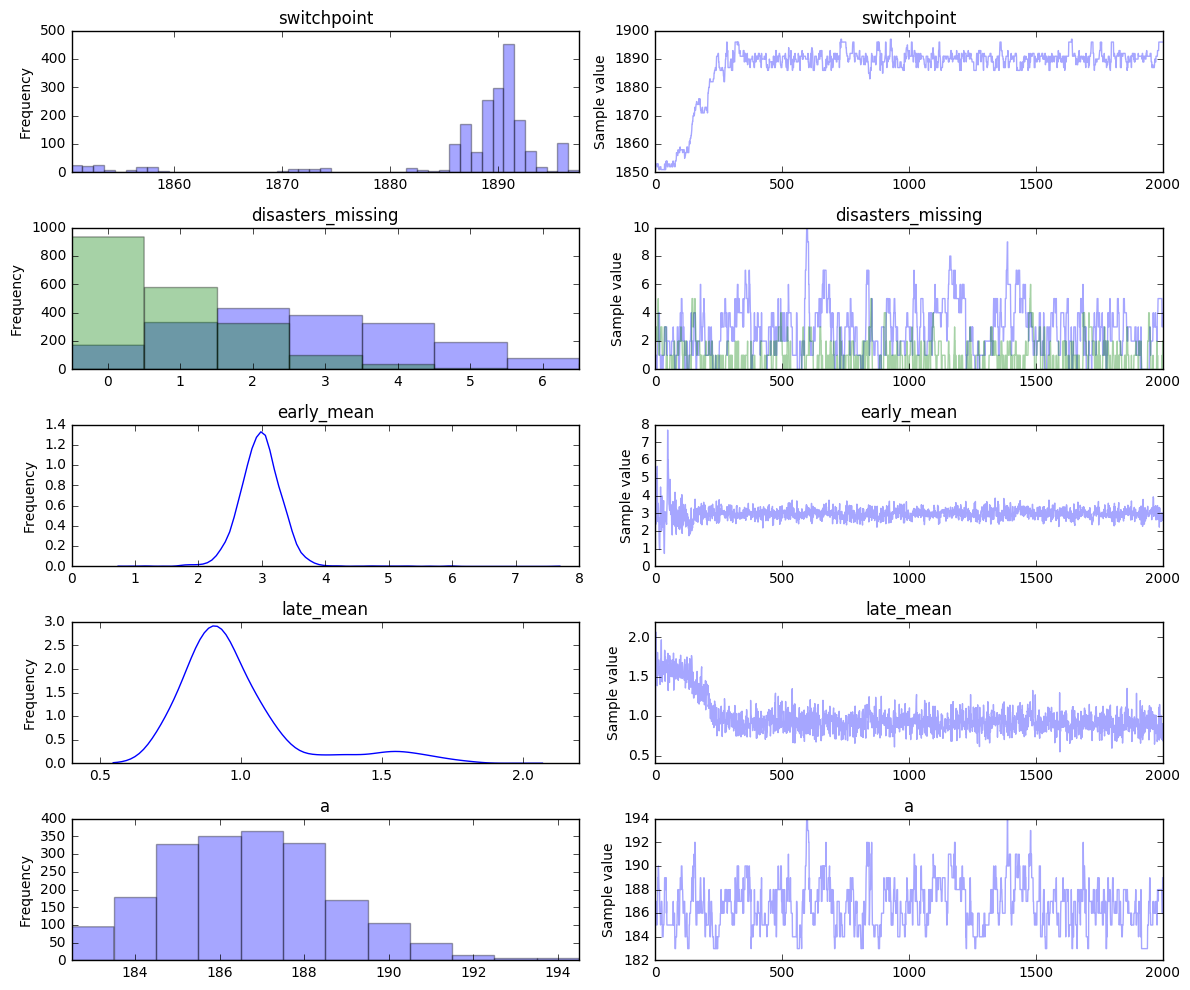

In [1]:
%matplotlib inline
"""
A model for coal mining disasters data with a changepoint

switchpoint ~ U(0, 110)
early_mean ~ Exp(1.)
late_mean ~ Exp(1.)
disasters[t] ~ Po(early_mean if t <= switchpoint, late_mean otherwise)

"""

import pymc3 as pm
import theano.tensor as tt
import numpy as np

# Time series of recorded coal mining disasters in the UK from 1851 to 1962
disasters_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, -1, 3, 3, 4, 0, 2, 6,
                                      3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                                      2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                                      1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                                      0, 1, 0, 1, 0, 0, 0, -1, 1, 0, 0, 0, 1, 1, 0, 2,
                                      3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                                      0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-1)
start_year = 1851
end_year = start_year + len(disasters_data)
n =2000

with pm.Model() as model:
    # Prior for distribution of switchpoint location
    switchpoint = pm.DiscreteUniform('switchpoint', lower=start_year, upper=end_year)
    # Priors for pre- and post-switch mean number of disasters
    early_mean = pm.Exponential('early_mean', lam=1.)
    late_mean = pm.Exponential('late_mean', lam=1.)

    # Allocate appropriate Poisson rates to years before and after current
    # switchpoint location
    idx = np.arange(start_year, end_year)
    rate = tt.switch(switchpoint >= idx, early_mean, late_mean)

    # Data likelihood
    disasters = pm.Poisson('disasters', rate, observed=disasters_data)
    b = tt.set_subtensor(rate[5], 12) 
    a = pm.Deterministic('a', disasters.sum())

    # Initial values for stochastic nodes
    start = {'early_mean': 2., 'late_mean': 3.}

    # Use slice sampler for means
    step1 = pm.Slice([early_mean, late_mean])
    # Use Metropolis for switchpoint, since it accomodates discrete variables   
    step2 = pm.Metropolis([switchpoint] + model.missing_values)

    tr = pm.sample(n, tune=500, start=start, step=[step1, step2])
    pm.traceplot(tr)

